# First Year Project - Project 1 - Corona and Weather

----
**Group 6 (F)**: Bjørn Søvad (bjso@itu.dk), Katarina Kraljevic (katkr@itu.dk), Mirka Katuscáková (katu@itu.dk), Emma Cecilie Bjerring Jensen (emcj@itu.dk), Viggo Yann Unmack Gascou (viga@itu.dk)

----

### Instructions for running this Jupyter Notebook
Make sure to run this notebook in trusted mode. \
This will ensure that the code blocks run correctly and display the output correctly

### Required Libraries
If needed you can read more documentation about the different libraries that are imported
* [Pandas Documentation](https://pandas.pydata.org/docs/)
* [Numpy Documentation](https://numpy.org/doc/)
* [Folium Documentation](https://python-visualization.github.io/folium/)
* [Json Documentation](https://docs.python.org/3/library/json.html)
* [Statsmodels Documentation](https://www.statsmodels.org/stable/)
* [Scipy Documentation](https://scipy.github.io/devdocs/index.html)

In [1]:
#Importing needed libraries
import pandas as pd                                                            # used to provide major datastructure pd.DataFrame() to store the datasets
import numpy as np                                                             # used for numerical calculations and fast array manipulations
import folium                                                                  # used for spatial data visualizations
import json                                                                    # used for loading json data correctly
import statsmodels.api as sm                                                   # used to run multivariate linear regression
from scipy.stats import pearsonr, spearmanr                                    # used to run 'pearson' and 'spearman' association tests of numerical variables on two variables
from statsmodels.stats.multitest import multipletests                          # used to run multiple tests of p-values for multiple variables
import matplotlib.pyplot as plt
from IPython.display import Markdown, display                                  # used to print stuff with markdown/HTML formatting for bold text and colored text
def printmd(string):
    display(Markdown(string))

ModuleNotFoundError: No module named 'pandas'

### Loading the raw data

In [ ]:
#Importing the raw corona data from Germany
corona_df = pd.read_csv('../data/raw/corona/de_corona.csv', sep = '\t')
corona_df.name = 'corona_df'

#Importing the raw weather data for the countries, Germany, Netherlands, Sweden and Denmark
weather_df = pd.read_csv("../data/raw/weather/weather.csv")
weather_df.name = 'weather_df'

#Loading in the metadata json using the Python json library
with open('../data/raw/metadata/de_metadata.json','r', encoding="utf8") as f:
    country_metadata=json.load(f)

#Creating a folium map (called de_map) that is based around Germany and uneditable in terms of placement and zoom
de_map = folium.Map(location = [51.1657, 10.4515], zoom_start = 6, crs = 'EPSG3857', 
    zoom_control = False, scrollWheelZoom = False, dragging = False)

#Loading in the geojson that contains data for the regions and borders of Germany and adding it to the folium map
folium.GeoJson('../data/raw/shapefiles/de.geojson', name = "geojson").add_to(de_map)
folium.LayerControl().add_to(de_map);

### Task 0: Data filtering and cleaning

The data analysis done in this notebook is done with a handful of different datasets:

> CSV: Corona (DE) - Contains the Number of new infections (per day) and Number of new casualties (per day) filtered by day and region in Germany for each day in the period `2020-01-02` to `2021-02-21`.
>
> CSV: Weather - Contains information about several indicators of weather conditions for each region in Germany, Denmark, Sweden and Netherlands for each day in the period `2020-02-13` to `2021-02-21`
>
> JSON: Metadata (DE) - Contains more information on the population in the different regions in Germany
>
> GEOJSON: Geojson (DE) - Holds the geojson data for the different regions in Germany

### Initial inspection of the datasets

In [ ]:
row, cols = weather_df.shape
print("Number of Rows: " + str(row))
print("Number of Columns: " + str(cols))
weather_df.head()

Number of Rows: 20220
Number of Columns: 9


,date,iso3166-2,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed
0,2020-02-13,DE-BB,76.337444,1.824290e+06,2.403341e+06,276.551573,0.003355,2.777806,4.542822
1,2020-02-13,DE-BE,76.065297,1.786373e+06,2.408182e+06,276.844633,0.003523,4.671329,4.761509
2,2020-02-13,DE-BW,80.113988,1.505760e+06,2.290158e+06,276.227143,0.008013,4.268546,4.467024
3,2020-02-13,DE-BY,81.554346,2.363013e+06,2.275361e+06,275.583053,0.005227,4.417797,3.677414
4,2020-02-13,DE-HB,87.167414,8.389756e+03,2.406940e+06,276.237452,0.007715,1.794872,4.699573


We can see that the `weather` dataset contains `9` different variables for the countries Germany, Denmark Sweden and Netherlands spread across `20220` rows and `9` columns. Each row contains `7` different weather measurements for a particular day in a specific country and region:
> `Date` (YYYY-DD-MM): Is the day of which the weather measurements were made and reported
>
> `Iso3166-2`: Is the [ISO 3166-2](https://en.wikipedia.org/wiki/ISO_3166-2) code for the region for which the weather measurements were made
>
> `Relative Humidity Surface` (%): Is the **daily average** relative humidity of the surface
>
> `Solar Radiation`(W/m^2): Is the **daily sum** of the solar radiation from the sun
>
> `Surface Pressure` (Pa): Is the **daily sum** of the atmospheric pressure at the surface of the earth
>
> `TemperatureAboveGround` (º K): Is the **daily average** of the temperature above ground
>
> `Total Precipitation` (mm): Is the **daily sum** of the total precipitation 
>
> `UV Index` (Numerical value): Is the **daily sum** of the strength of the ultraviolet radiation
>
> `Wind Speed`(m/s): Is the **daily average** of the wind speed

In [ ]:
row, cols = corona_df.shape
print("Number of Rows: " + str(row))
print("Number of Columns: " + str(cols))
corona_df.head()

Number of Rows: 5602
Number of Columns: 4


,date,region_code,confirmed_addition,deceased_addition
0,2020-01-02,Nordrhein-Westfalen,1,0
1,2020-01-07,Nordrhein-Westfalen,1,0
2,2020-01-09,Nordrhein-Westfalen,1,1
3,2020-01-12,Nordrhein-Westfalen,1,0
4,2020-01-14,Nordrhein-Westfalen,1,0


We can see that the `corona` dataset contains `4` different variables for corona reports for Germany spread across `5602` rows and `4` columns. Each row contains `2` different corona reports for a particular day in a specific country and region:
> `Date` (YYYY-DD-MM): Is the day of which the corona report was made
>
> `Region Code`: Is the region code for the region for which the corona report was made
>
> `Confirmed Addition`: Is the number of new confirmed infections of corona for the specific day in the specified region
>
> `Deceased Addition`: Is the number of newly confirmed deaths for the specific day in the specified region

### Sanity check
Checking to see if there are any missing (Na or NaN) values in either of the two datasets \
\
We also check if there are any duplicate rows in either of the two datasets.

### Checking for NaN values:

In [ ]:
datasets = [weather_df, corona_df]
for dataset in datasets:
    if dataset.name == "weather_df":
        printmd("### **Weather Dataset**")
    else: 
        printmd("### **Corona Dataset**")

    print(dataset.isnull().any())
    print("-----------------------------------------------")
    printmd( "##### <span style='color:red'> ❌ **Oh No! There are missing data values in the dataset!**</span>" if dataset.isnull().any().any() 
            else
            "##### <span style='color:lightgreen'> ✅ **Great! There are no missing data values in the dataset!**</span>")
    printmd("____")

### **Weather Dataset**

date                       False
iso3166-2                  False
RelativeHumiditySurface    False
SolarRadiation             False
Surfacepressure            False
TemperatureAboveGround     False
Totalprecipitation         False
UVIndex                    False
WindSpeed                  False
dtype: bool
-----------------------------------------------


##### <span style='color:lightgreen'> ✅ **Great! There are no missing data values in the dataset!**</span>

____

### **Corona Dataset**

date                  False
region_code           False
confirmed_addition    False
deceased_addition     False
dtype: bool
-----------------------------------------------


##### <span style='color:lightgreen'> ✅ **Great! There are no missing data values in the dataset!**</span>

____

### Checking for duplicates:

In [ ]:
for dataset in datasets:
    if dataset.name == "weather_df":
        printmd("### **Weather Dataset**")
    else: 
        printmd("### **Corona Dataset**")

    print(dataset.duplicated())
    print("-----------------------------------------------")
    printmd( "##### <span style='color:red'> ❌ **Oh No! There are duplicate data values in the dataset!**</span>" if dataset.duplicated().any() 
            else
            "##### <span style='color:lightgreen'> ✅ **Great! There are no duplicate data values in the dataset!**</span>")
    printmd("____")

### **Weather Dataset**

0        False
1        False
2        False
3        False
4        False
         ...  
20215    False
20216    False
20217    False
20218    False
20219    False
Length: 20220, dtype: bool
-----------------------------------------------


##### <span style='color:lightgreen'> ✅ **Great! There are no duplicate data values in the dataset!**</span>

____

### **Corona Dataset**

0       False
1       False
2       False
3       False
4       False
        ...  
5597    False
5598    False
5599    False
5600    False
5601    False
Length: 5602, dtype: bool
-----------------------------------------------


##### <span style='color:lightgreen'> ✅ **Great! There are no duplicate data values in the dataset!**</span>

____

Since there are no missing data values we can move on to cleaning and filtering the data.

#### _Let's start by cleaning and filtering the corona data for Germany:_

We first start of by creating to dictionaries that are going to help us to map both regions and their populations to the dataframes:

In [ ]:
#Creating a dictionary that contains the full names of the different regions as keys and their respective iso3166-2 code as values
region_map = {country_metadata["country_metadata"][i]["covid_region_code"]: 
    country_metadata["country_metadata"][i]["iso3166-2_code"] for i in range(len(country_metadata["country_metadata"]))}

#Creating a dictionary that contains the full names of the different regions as keys and their respective populations as values
population_map = {country_metadata["country_metadata"][i]["iso3166-2_code"]: 
    country_metadata["country_metadata"][i]["population"] for i in range(len(country_metadata["country_metadata"]))}

Now with the region_map we can create extra columns to add the iso3166-2 code to the corona dataframe as it only contained to full region codes. \
\
We can also use the population_map to add a column with the population of each of the regions to the corona dataframe. \
\
With the population column we can create a column that contains the cases and deaths per capita using the confirmed addition and the population column we just created.

In [ ]:
#Using the region_map dictionary to create a new column with the respective iso3166-2 code for each region based on the full region name
#from the region_code column
corona_df["iso3166-2"] = corona_df["region_code"].map(region_map)

#Using the population_map dictionary to create a new column with the respective population for each region based on the iso3166-2 code
#from the iso3166-2 column
corona_df["population"] = corona_df["iso3166-2"].map(population_map)

#Also adding a cases and deaths per capita column that is created using the confirmed covid cases and deaths respectively divided by the population in that region
corona_df["cases_pc"] = corona_df["confirmed_addition"] / corona_df["population"]
corona_df["deaths_pc"] = corona_df["deceased_addition"] / corona_df["population"]

#### _Now moving on to the weather dataset:_

We start of by first filtering out all the other countries from the dataset as we are not interested in their data.\
\
We can then convert the temperature measurements from º K to º C, we do that by subtracting `273.15` from each row value in the temperature measurements \
\
We also need to divide each UVIndex value with 24 because these values were measured every hour over one day (24 hours) and then summed giving abnormaly high UV index values

<span style='color:IndianRed'>Please note: Be careful to not run the following cell more than once as this will keep doing the subtractions and divisions which could lead to abnormal temperature and UV values</span>

In [ ]:
#Filtering out all the weather data that is not relevant as we are only interested in weatherdata from Germany
weather_df = weather_df[weather_df["iso3166-2"].str.startswith("DE")]

#Converting the temperature from Kelvin to Celsius
weather_df["TemperatureAboveGround"] = weather_df["TemperatureAboveGround"] - 273.15

#Correcting the UVIndex from a sum of the UVIndex to average UVIndex for a given day
weather_df["UVIndex"] = weather_df["UVIndex"] / 24

C:\Users\katus\AppData\Local\Temp/ipykernel_24180/2479171852.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_df["TemperatureAboveGround"] = weather_df["TemperatureAboveGround"] - 273.15
C:\Users\katus\AppData\Local\Temp/ipykernel_24180/2479171852.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_df["UVIndex"] = weather_df["UVIndex"] / 24


Finally we can merge the corona_df and the weather_df to create on big dataframe/dataset that contains all the data that we need.

In [ ]:
#Merging the weatherdata with the coronadata to create one dataframe with all the data that we need
merged_df = corona_df.merge(weather_df)

Now having cleaned and filtered to two datasets we can create new `.csv` files that we can use for the rest of this notebook. \
\
We do this by using the built-in pandas function `pd.to_csv` that will automatically convert the pandas dataframe to a `.csv` file \
\
We will also create shortcuts to those files so the code becomes more human readable.

In [ ]:
# The pd.to_csv function is run by first specifying the file path and name that it should create.
# The index = False argument specifies to the function that the .csv file should not include the index
# that the pandas dataframe has
corona_df.to_csv("../Data/processed/de_corona.csv", index = False)
weather_df.to_csv("../Data/processed/de_weather.csv", index = False)
merged_df.to_csv("../Data/processed/de_corona_weather.csv", index = False)

# Now creating the shortcuts to the processed datasets
corona_path = "../Data/processed/de_corona.csv"
weather_path = "../Data/processed/de_weather.csv"
merged_path = "../Data/processed/de_corona_weather.csv"

We can now read in and overwrite the name variables of the datasets to make sure that the data we use has been filtered and cleaned correctly:

In [ ]:
corona_df = pd.read_csv(corona_path)
weather_df = pd.read_csv(weather_path)
merged_df = pd.read_csv(merged_path)

### Task 1: Single variable analysis

In [ ]:
merged_df.set_index('date', inplace=True)

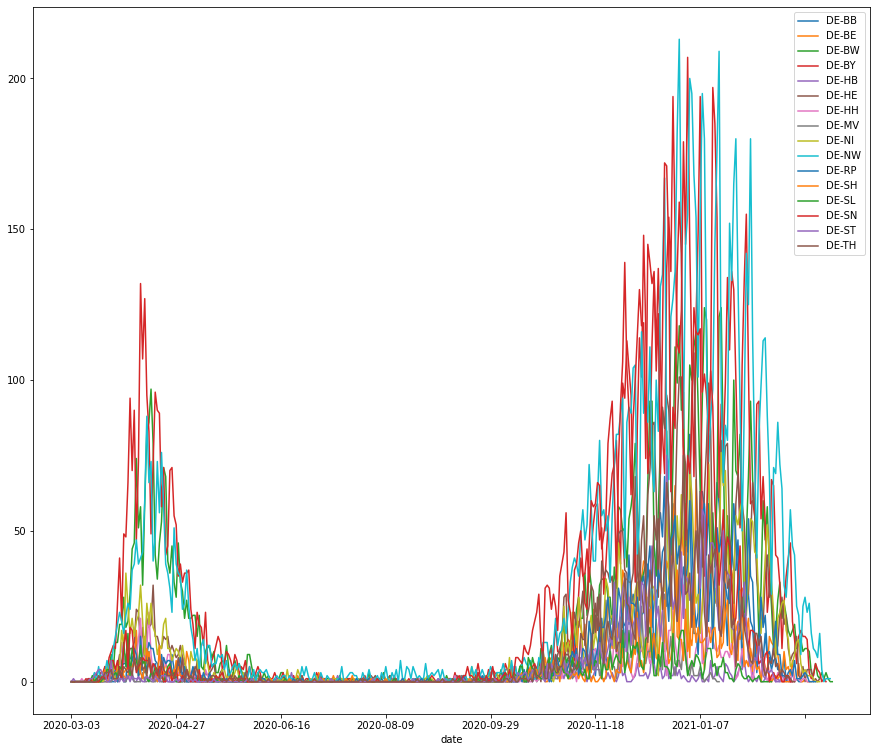

In [ ]:
merged_df.groupby('iso3166-2')['deceased_addition'].plot(kind="line",legend=True, figsize=(15,13))
plt.show()


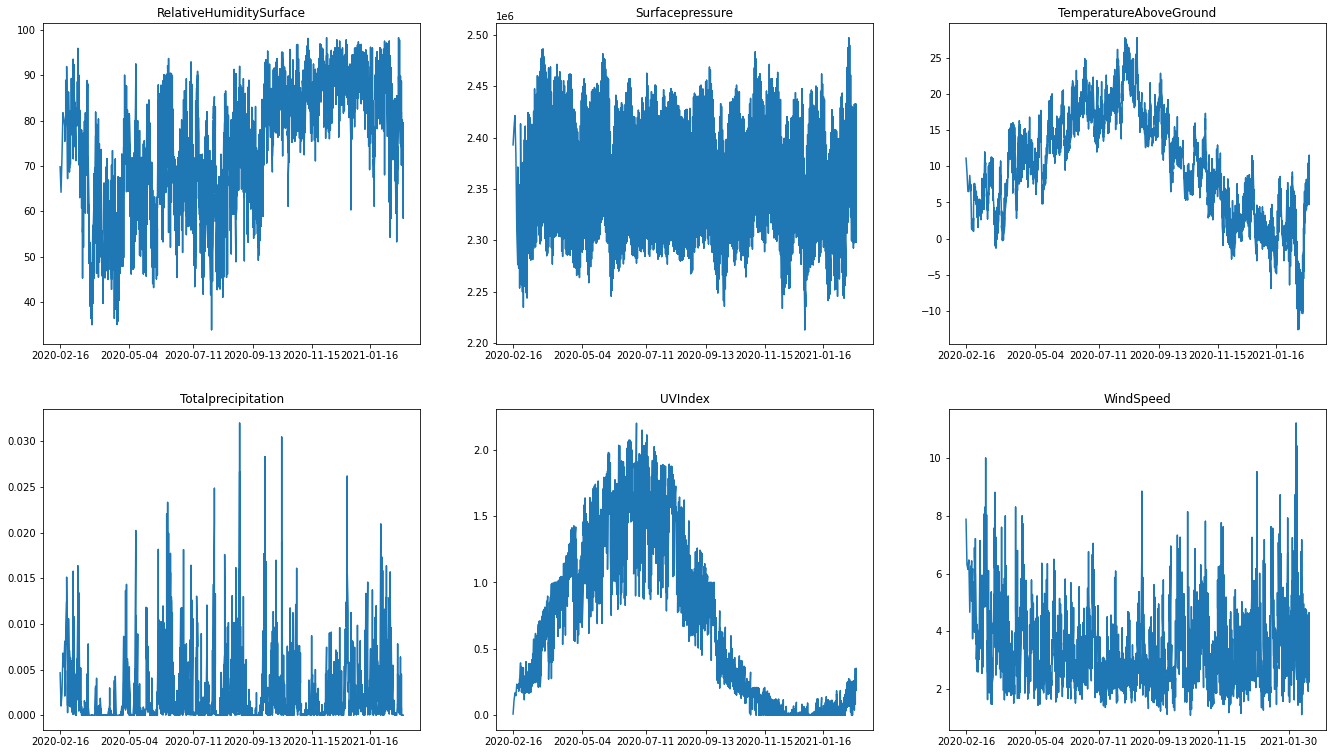

In [ ]:
#weatherdata
fig, ax = plt.subplots(2,3,figsize=(23,13))

ax[0][0].plot(merged_df['RelativeHumiditySurface'])
ax[0, 0].set_title('RelativeHumiditySurface')
ax[0,0].set_xticks(['2020-02-16','2020-05-04','2020-07-11','2020-09-13','2020-11-15','2021-01-16'])
ax[0][1].plot(merged_df['Surfacepressure'])
ax[0, 1].set_title('Surfacepressure')
ax[0,1].set_xticks(['2020-02-16','2020-05-04','2020-07-11','2020-09-13','2020-11-15','2021-01-16'])
ax[0][2].plot(merged_df['TemperatureAboveGround'])
ax[0, 2].set_title('TemperatureAboveGround')
ax[0,2].set_xticks(['2020-02-16','2020-05-04','2020-07-11','2020-09-13','2020-11-15','2021-01-16'])
ax[1][0].plot(merged_df['Totalprecipitation'])
ax[1, 0].set_title('Totalprecipitation')
ax[1,0].set_xticks(['2020-02-16','2020-05-04','2020-07-11','2020-09-13','2020-11-15','2021-01-16'])
ax[1][1].plot(merged_df['UVIndex'])
ax[1, 1].set_title('UVIndex')
ax[1,1].set_xticks(['2020-02-16','2020-05-04','2020-07-11','2020-09-13','2020-11-15','2021-01-16'])
ax[1][2].plot(merged_df['WindSpeed'])
ax[1, 2].set_title('WindSpeed')
ax[1,2].set_xticks(['2020-02-16','2020-05-04','2020-07-11','2020-09-13','2020-11-15','2021-01-30'])
# plt.xticks()
